# Robot-Run Cafe in Los Angeles

We are contemplating the idea of launching a small cafe in Los Angeles that would be run by robots. To evaluate this venture, we have conducted market research based on open-source data.

## Data description

- `rest_data` table:
- `object_name` — establishment name
- `chain` — chain establishment (TRUE/FALSE)
- `object_type` — establishment type
- `address` — address
- `number` — number of seats


# Initialization


Installing packages:


In [1]:
!pip install -qq usaddress 
!pip install -Uq --user plotly

Loading libraries:

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import usaddress

In [3]:
plt.rcParams["figure.figsize"] = (8, 4) 	# matplotlib+seaborn figure size
pio.templates.default = "seaborn"			# plotly color template (global)
#px.defaults.template = "seaborn"			# plotly express color template 

pd.set_option("max_colwidth", 300)

warnings.filterwarnings("ignore")

# Preprocessing


Loading data


In [4]:
rest = pd.read_csv("rest_data_us.csv")

## `data` table


In [5]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


Checking NAs in `chain`:

In [6]:
rest[rest['chain'].isna()]

id              object_name               address chain object_type  \
7408  19194  TAQUERIA LOS 3 CARNALES  5000 E WHITTIER BLVD   NaN  Restaurant   
7523  19309     JAMMIN JIMMY'S PIZZA   1641 FIRESTONE BLVD   NaN       Pizza   
8648  20434    THE LEXINGTON THEATER          129 E 3RD ST   NaN  Restaurant   

      number  
7408      14  
7523       1  
8648      35

These restaurants don't belong to chains. Filling NAs with `False`

In [7]:
rest['chain'].fillna(False, inplace=True)

In [8]:
rest.describe()

id       number
count   9651.000000  9651.000000
mean   16611.000000    43.695161
std     2786.148058    47.622874
min    11786.000000     1.000000
25%    14198.500000    14.000000
50%    16611.000000    27.000000
75%    19023.500000    46.000000
max    21436.000000   229.000000

In [9]:
rest.head(10)

id          object_name                          address  chain  \
0  11786  HABITAT COFFEE SHOP           3708 N EAGLE ROCK BLVD  False   
1  11787             REILLY'S              100 WORLD WAY # 120  False   
2  11788       STREET CHURROS        6801 HOLLYWOOD BLVD # 253  False   
3  11789    TRINITI ECHO PARK               1814 W SUNSET BLVD  False   
4  11790               POLLEN               2100 ECHO PARK AVE  False   
5  11791       THE SPOT GRILL              10004 NATIONAL BLVD  False   
6  11792                  CPK              100 WORLD WAY # 126  False   
7  11793             PHO LALA            3500 W 6TH ST STE 226  False   
8  11794           ABC DONUTS  3027 N SAN FERNANDO RD UNIT 103   True   
9  11795             UPSTAIRS             3707 N CAHUENGA BLVD  False   

  object_type  number  
0        Cafe      26  
1  Restaurant       9  
2   Fast Food      20  
3  Restaurant      22  
4  Restaurant      20  
5  Restaurant      14  
6  Restaurant     100  
7  Restaurant       7  
8   Fast Food       1  
9  Restaurant      35

In [10]:
rest['object_type'].unique()

array(['Cafe', 'Restaurant', 'Fast Food', 'Bakery', 'Bar', 'Pizza'],
      dtype=object)

In [11]:
rest = rest.astype({'chain': 'bool', 'object_type': 'category'})

Data looks clean. Did minor transformations: 
* filled 3 NA values
* changed data types of some columns 

# Restaurants on the Map

Before we begin, let's take a bird's-eye view of the location of restaurants in LA on the map.

Geocoding the addresses:

In [12]:
#####################
# I geocoded the restaurant addresses using this code. But since it took almost two hours to run, 
# I saved the result in a separate file. 
#####################

### Original code
#
# from geopy.geocoders import Nominatim
# import time
#
# geolocator = Nominatim(user_agent="my-app")
# addresses = rest[['id','address']]
# def geocode_with_retry(address):
#     max_retries = 10
#     for i in range(1, max_retries):
#         try:
#             location = geolocator.geocode(address)
#             if location is not None:
#                 return location.latitude, location.longitude
#             else:
#                 return None, None
#         except:
#             print(f'Geocoder unavailable, retrying in {i} seconds...')
#             time.sleep(i)
#     print(f'Geocoding failed after {max_retries} retries')
#     return None, None
#
# addresses[['latitude', 'longitude']] = pd.DataFrame((addresses['address']).apply(lambda x: geocode_with_retry(x.split("#")[0]+', Los Angeles, CA, USA')).tolist())
# addresses.to_csv('addresses.csv', index=False)

### Replacement code
addresses = pd.read_csv('addresses.csv')

#####################

print(f"Geocoded successfully: {(~addresses['longitude'].isna()).sum()} "
      f"out of {len(addresses)} addresses "
      f"({(~addresses['longitude'].isna()).sum()/len(addresses):.0%})")

Geocoded successfully: 7826 out of 9651 addresses (81%)


In [13]:
# Merging coordinates with the main table.
rest = rest.merge(addresses[['id','latitude','longitude']], on='id')

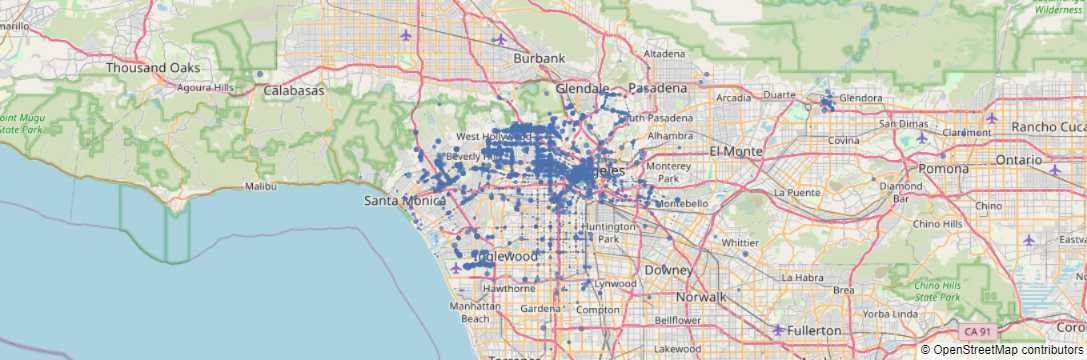

In [14]:
fig = px.scatter_mapbox(
    rest[~rest['latitude'].isna()], 
    lat='latitude', 
    lon='longitude', 
    hover_name='object_name',
#     color='object_type',
    size='number',
    size_max=5,
    zoom=9,
    # height=1000
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Data Analysis


## Investigate proportions of the various types of establishments


In [15]:
len(rest)

9651

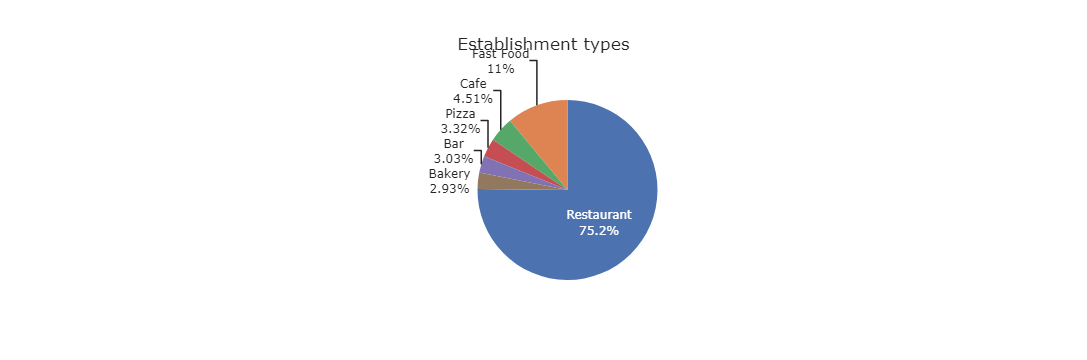

In [16]:
rest_type = rest.groupby('object_type')['id'].count().reset_index().sort_values(by='id', ascending=False)
rest_type.columns = ['est_type','count']
#display(rest_type)
fig = px.pie(
    rest_type, 
    values='count', 
    names='est_type',
    title='Establishment types',
)
fig.update_traces(
    textposition='auto', 
    textinfo='percent+label',
    showlegend=False)
fig.show()

Observations:

- Restaurants make up over 75% of the market.
- Fast food establishments represent a respectable 11%, which is noteworthy given that all other types of establishments are under 5%.
- Cafes make up 4.5% of the market, while bakeries account for 2.9%.


## Investigate proportions of chain and nonchain establishments

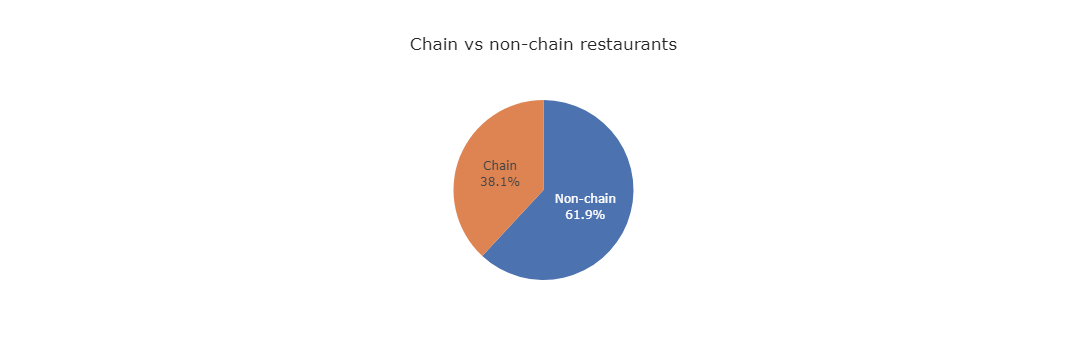

In [17]:
fig = px.pie(
    rest.groupby('chain')['object_name'].count().reset_index().replace({True: 'Chain', False: 'Non-chain'}), 
    values='object_name',
    names='chain',
    title='Chain vs non-chain restaurants')
fig.update_traces(textposition='auto', textinfo='percent+label', showlegend=False)
fig.show()

We can also note that almost 62% of the establishments are nonchain establishments. On the other hand, 38% of the establishments belong to chains.


## Which type of establishment is typically a chain?


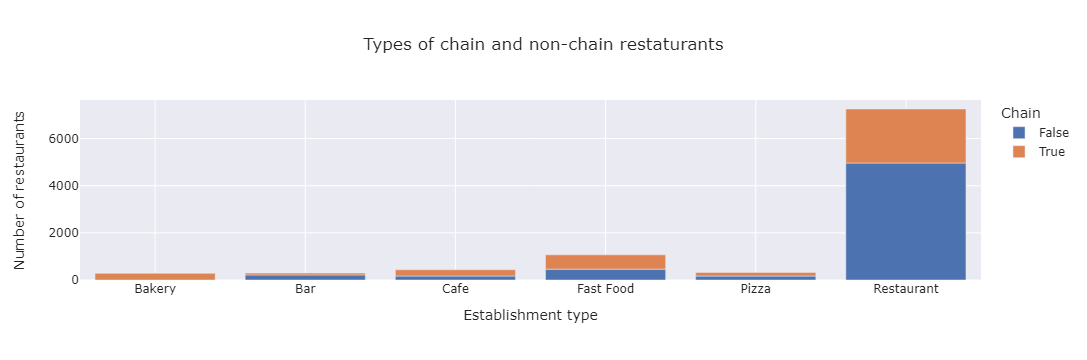

In [18]:
rest_types = rest.pivot_table(
		index='object_type',
		columns='chain',
		values='id',
		aggfunc='count')
#display(rest_types)

fig = px.bar(
    rest_types, 
    title='Types of chain and non-chain restaturants',
    labels={'value':'Number of restaurants', 'object_type':'Establishment type','chain':'Chain'},
#    text_auto=True
)
fig.show()

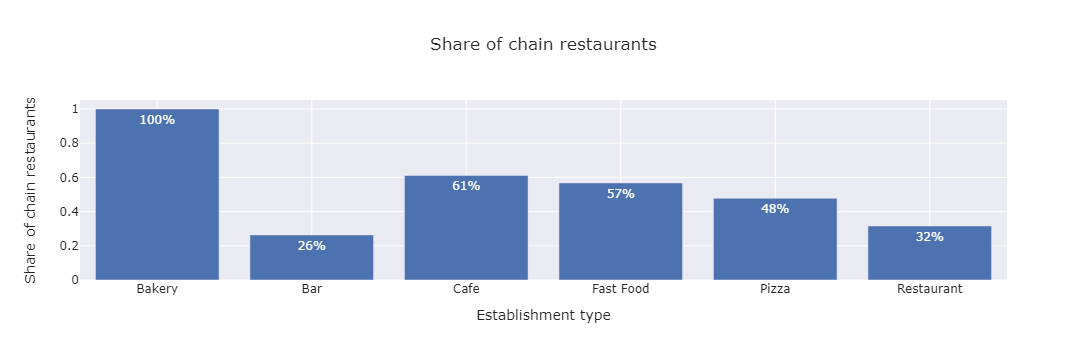

In [19]:
fig = px.bar(
    rest_types[True] / ( rest_types[True]+rest_types[False]), 
    title='Share of chain restaurants',
    text_auto='.0%',
    labels={'value':'Share of chain restaurants', 'object_type':'Establishment type'}
)
fig.update_layout(showlegend=False)
fig.show()

Observations:

- All bakeries belong to chains
- Bars are the least likely to belong to chains (only 26%)


## What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?


In [20]:
chains = rest[rest['chain'] == True
    ].groupby('object_name')['id', 'number'
    ].agg({'id': 'count', 'number': 'median'}
    ).rename(columns={'id': 'count', 'number': 'median_seats'}
 	).sort_values(by='count', ascending=False)

chains.head(10)

count  median_seats
object_name                                    
THE COFFEE BEAN & TEA LEAF     47          24.0
SUBWAY                         31          16.0
DOMINO'S PIZZA                 15          12.0
WABA GRILL                     14          41.5
KENTUCKY FRIED CHICKEN         14          31.5
MCDONALD'S                     13         100.0
TRIMANA                        13          33.0
STARBUCKS                      12          19.0
PAPA JOHN'S PIZZA              12          10.0
YOGURTLAND                     12          18.0

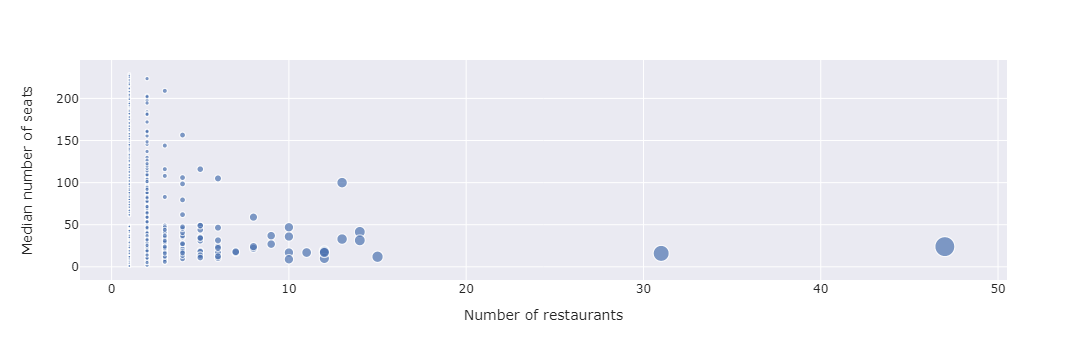

In [21]:
fig = px.scatter(
	chains,
	x='count',
	y='median_seats',
	labels={'count':'Number of restaurants', 'median_seats':'Median number of seats'},
	size='count',
)
fig.show()

Obeservation: the bigger the chain, the less median number of seats it has.

## Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats? Plot graphs


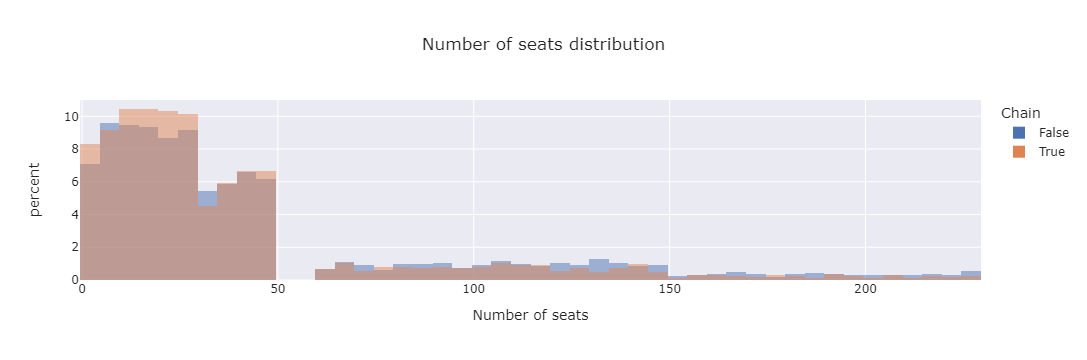

In [22]:
fig = px.histogram(
    rest, 
    x='number', 
    color = 'chain',  
    barmode='overlay',
    title="Number of seats distribution",
    histnorm='percent',
    labels={'number':'Number of seats', 'chain':'Chain'}
    )
fig.show()

Observations:

- Chain and non-chain restaurants have similar distribution the number of seats
- Most establishments have fewer than 50 seats
- For some reason there are no establishments in the dataset that have between 50 and 60 seats.

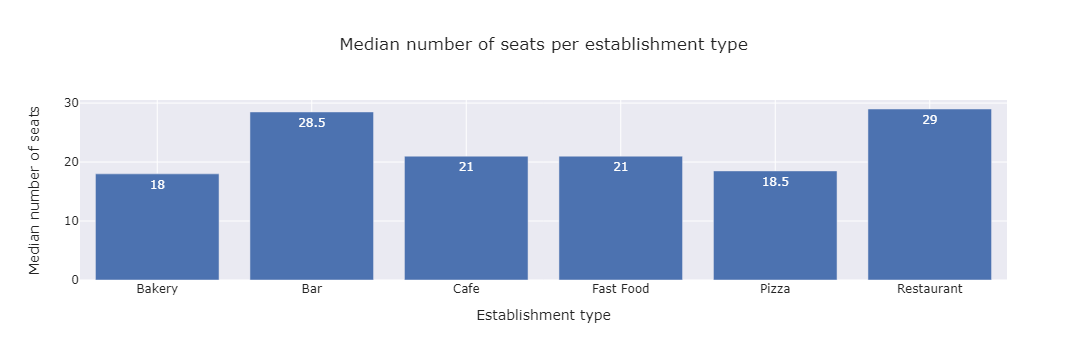

In [23]:
fig = px.bar(
    rest.pivot_table(
		index='object_type',
		values='number',
		aggfunc='median',
	),
    title='Median number of seats per establishment type',
	text_auto=True,
	labels={'value':'Median number of seats', 'object_type':'Establishment type'},
)
fig.update_traces(showlegend=False)
fig.show()

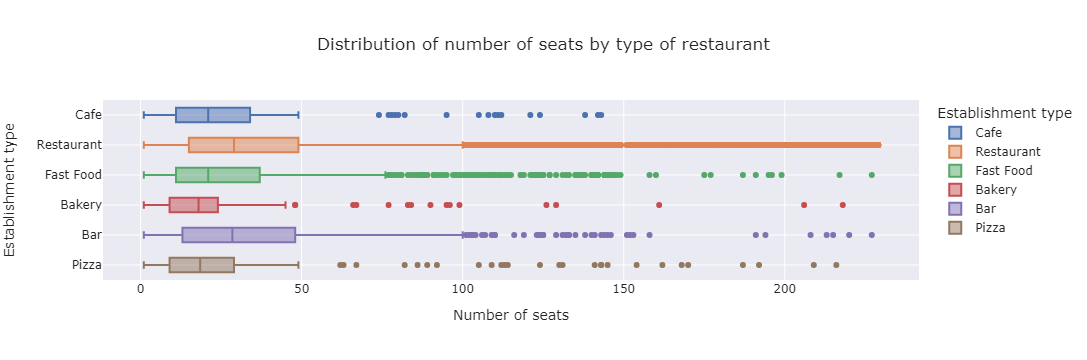

In [24]:
fig = px.box(
	rest,
	x='number',
 	y='object_type',
	color='object_type',
	title='Distribution of number of seats by type of restaurant',
	labels={'number':'Number of seats', 'object_type':'Establishment type'}
)
fig.show()

Observations:
- Restaurants and bars have the highest mean number of seats: 48 and 45
- Bakeries have the lowest mean number of seats - 21. Probably because many people use it as takeaways.


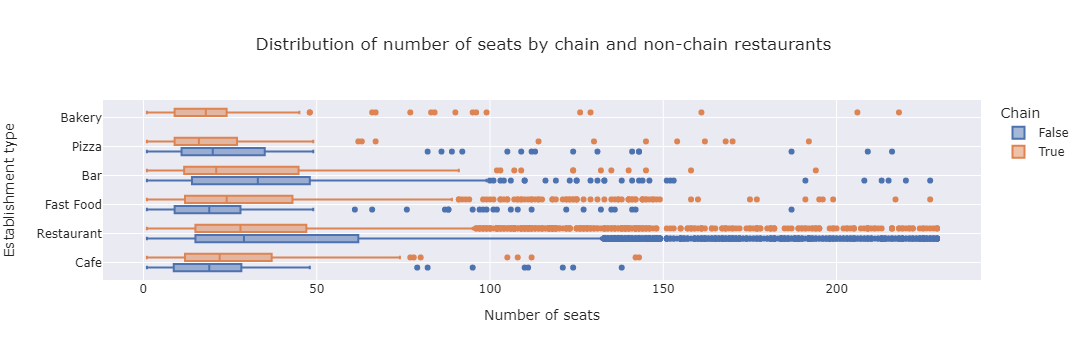

In [25]:
fig = px.box(
	rest,
	x='number',
 	y='object_type',
	color='chain',
	title='Distribution of number of seats by chain and non-chain restaurants',
	labels={'number':'Number of seats', 'object_type':'Establishment type', 'chain':'Chain'}
)
fig.show()

Chain establishments in the fast food and cafe categories typically have a greater number of seats than non-chain establishments, while in all other categories, they tend to have a smaller number of seats.  

## Put the data on street names from the address column in a separate column


In [26]:
def extract_street(address):
    parsed_address = usaddress.parse(address)
    street = ''
    for component in parsed_address:
        if component[1] == 'StreetName':
            street += component[0] + ' '
    return street.strip()

rest['street'] = rest['address'].apply(extract_street)
rest.head()

id          object_name                    address  chain object_type  \
0  11786  HABITAT COFFEE SHOP     3708 N EAGLE ROCK BLVD  False        Cafe   
1  11787             REILLY'S        100 WORLD WAY # 120  False  Restaurant   
2  11788       STREET CHURROS  6801 HOLLYWOOD BLVD # 253  False   Fast Food   
3  11789    TRINITI ECHO PARK         1814 W SUNSET BLVD  False  Restaurant   
4  11790               POLLEN         2100 ECHO PARK AVE  False  Restaurant   

   number   latitude   longitude      street  
0      26        NaN         NaN  EAGLE ROCK  
1       9  33.945488 -118.399701       WORLD  
2      20  34.102690 -118.340469   HOLLYWOOD  
3      22  34.068635 -118.469970      SUNSET  
4      20  34.089478 -118.249866   ECHO PARK

## Plot a graph of the top ten streets by number of restaurants


In [27]:
rest_by_street = rest.groupby('street')['id'].count().sort_values(ascending=False)
rest_by_street.head(10)

street
SUNSET          404
WILSHIRE        398
PICO            370
WESTERN         369
FIGUEROA        334
OLYMPIC         309
VERMONT         288
SANTA MONICA    264
3RD             263
HOLLYWOOD       253
Name: id, dtype: int64

In [28]:
len(rest_by_street)

491

There are 491 streets with restaurants in LA

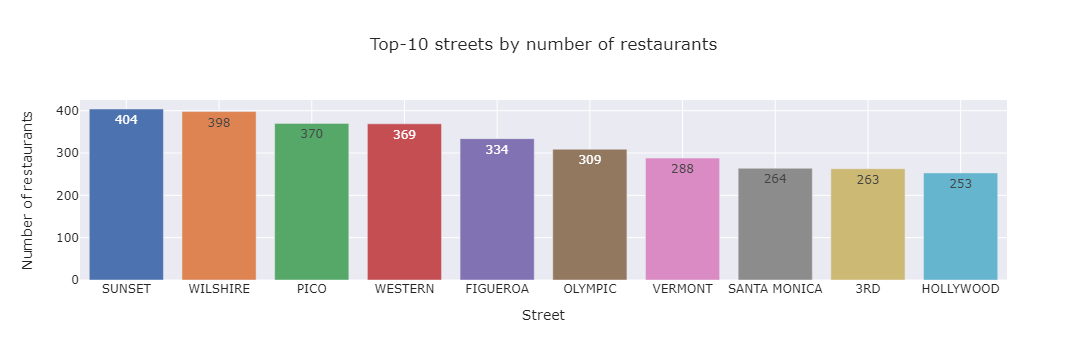

In [29]:
fig = px.bar(
	rest_by_street.head(10),
	title='Top-10 streets by number of restaurants',
	text='value',
	color = rest_by_street.head(10).index,
	labels={'street':'Street', 'value':'Number of restaurants'}
)
fig.update_layout(showlegend=False)
fig.show()

Out of the 491 streets in the dataset, the top 10 streets account for 34% of all restaurants, with each of these streets having an average of 325 (!) restaurants. The street with the highest number of restaurants is Sunset Street, with a total of 404 restaurants.


In [1]:
rest['is_top_10'] = rest['street'].isin(rest_by_street.head(10).index)
fig = px.scatter_mapbox(
    rest[~rest['latitude'].isna()], 
    lat='latitude', 
    lon='longitude', 
    hover_name='object_name',
    color='is_top_10',
    size='number',
    size_max=5,
    zoom=10,
    # height=1000
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

NameError: name 'rest' is not defined

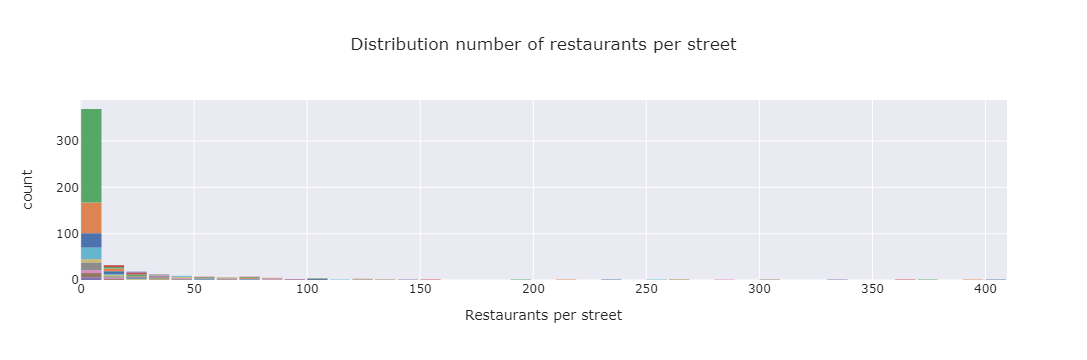

In [33]:
fig = px.histogram(
	rest_by_street,
	title = 'Distribution number of restaurants per street',
	color='value',
    labels={'value':'Restaurants per street', 'count':'Number of streets'}
) 
fig.update_layout(bargap=0.1,showlegend=False)
fig.show()


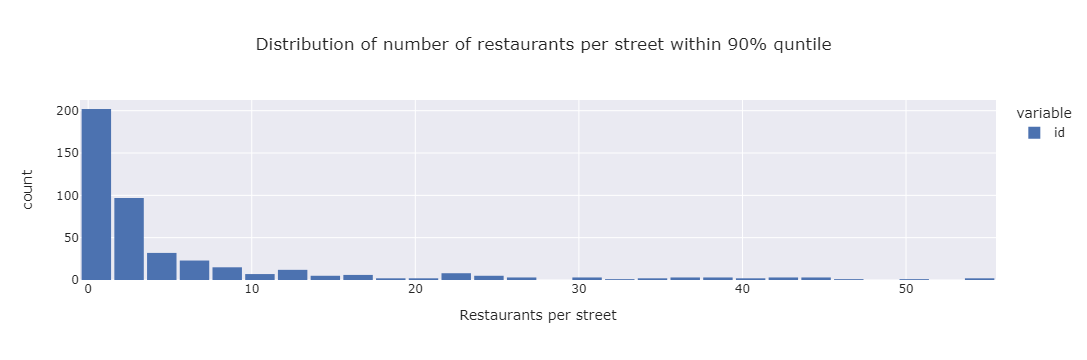

In [34]:
quantile = 90
fig = px.histogram(
	rest_by_street[rest_by_street.values <= np.percentile(rest_by_street.values, quantile)],
	title = f"Distribution of number of restaurants per street within {quantile}% quntile",
    labels={'value':'Restaurants per street', 'count':'Number of streets'}
) 
fig.update_layout(bargap=0.1)
fig.show()

70% of streets have less than 10 resturants


## Find the number of streets that only have one restaurant


In [35]:
print(f"Number of streets that only have one restaurant: {rest_by_street[rest_by_street.values==1].sum()}")

Number of streets that only have one restaurant: 202


## For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?


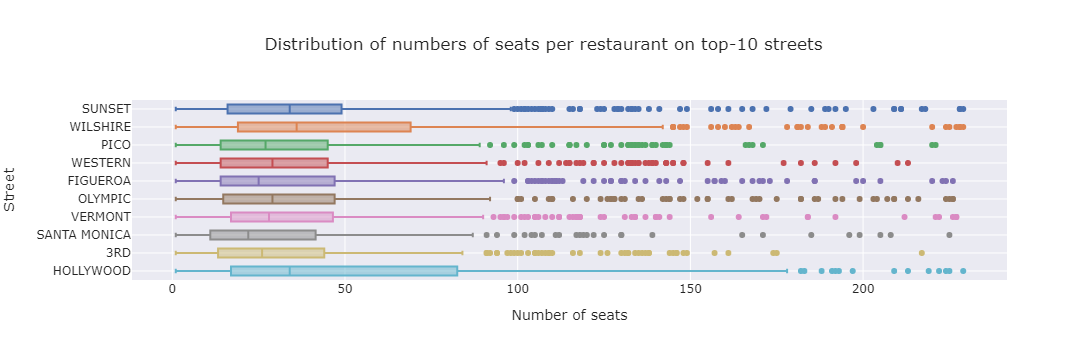

In [36]:

fig = px.box(
	rest[rest['street'].isin(rest_by_street.head(10).index)],
	x='number',
	y='street',
	color='street',
	title='Distribution of numbers of seats per restaurant on top-10 streets',
	category_orders={'street':rest_by_street.head(10).index},
	labels={'street':'Street', 'number':'Number of seats'}
)
fig.update_layout(showlegend=False)
fig.show()

Wilshire street has the largest median number of seats.


# Conclusion and recommendations <a id="two.ten"></a>


**Findings**

* Most establishments in Los Angeles are restaurants, making up 75% of the market
* In Los Angeles, 62% of establishments are independently owned, while the remaining 38% are chain establishments.
* The highest share of chain establishments is in Bakeries (100%). The lowest share is among Bars (26%). 
* Chain and non-chain restaurants have similar distribution the number of seats. Most establishments have fewer than 50 seats
* For some reason there are no establishments in the dataset that have between 50 and 60 seats.
* Restaurants and bars have the highest median number of seats at 29 and 28.5, respectively. Bakeries have the lowest mean number of seats, which is 18, likely because many customers prefer to order takeaways.
* Chain establishments in the fast food and cafe categories tend to have more seats than non-chain establishments, while in all other categories, they tend to have fewer seats.
* The top 10 streets out of 491 streets in the dataset account for 34% of all restaurants, with each street averaging 325 restaurants. Meanwhile, 70% of streets have less than 10 restaurants. Sunset Boulevard has the highest number of restaurants, with a total of 404.

**Recommendations**

We recommend considering the possibility of launching a bar based on the following factors:

- Bars are generally preferred by customers who value small, genuine settings, leading to a minimal presence of chains in this market.
- In Los Angeles, bars have the lowest representation among all categories (excluding bakeries, which are not relevant since they are completely dominated by chains).